In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#imports for kears and ML
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.utils import plot_model
from sklearn.model_selection import train_test_split

#imports from rdkit
from rdkit import Chem
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import AllChem

Using TensorFlow backend.


In [2]:
# function defintions go here

def get_smiles_HLgap(filename):
    # function for reading xyz file
    myfile = open(filename, "r")
    lines = myfile.readlines()
    N_atoms = np.int(lines[0].split()[0])
    HL_gap = np.float(lines[1].split()[9])
    smiles = np.str(lines[N_atoms+3]).split()[0]
    return smiles, HL_gap

def smiles_to_fp(smiles, nbits):
    # function for generate molecular fingerprint
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=nbits)
    return fp

In [13]:
# read the data 
# I download this data from http://qmml.org/datasets.html

root = "/Users/samuelflender/Downloads/gdb9-14/dsgdb9nsd.xyz/"
list_files = os.listdir(root)
N_mols = len(list_files)
print "total number of molecules: ", N_mols

N_subset = 133885
nbits = 128

smiles = []
HL_gap = []
fingerprint = []
count=0

for filename in list_files[0:N_subset]:
    smi, hlg = get_smiles_HLgap(root+filename)
    smiles.append(smi)
    HL_gap.append(hlg)
    fp = smiles_to_fp(smi,nbits)
    fingerprint.append(fp)

total number of molecules:  133885


In [14]:
# get the data into pandas dataframe

df = pd.DataFrame()
for j in range(nbits):
    df["bit"+str(j)]=[fingerprint[i][j] for i in range(len(fingerprint))]

target = pd.Series(HL_gap)

In [55]:
df.head(5)

,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,bit9,...,bit118,bit119,bit120,bit121,bit122,bit123,bit124,bit125,bit126,bit127
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
target.head(5)

0    0.5048
1    0.3399
2    0.3615
3    0.3351
4    0.3796
dtype: float64

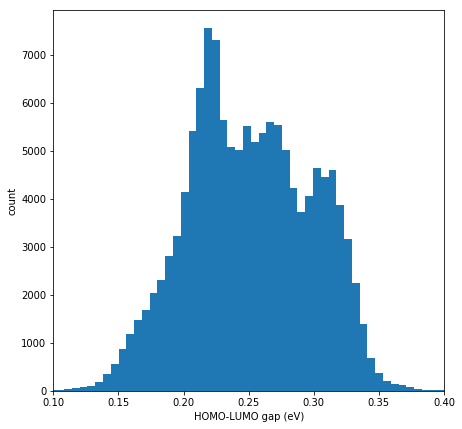

In [15]:
# plot the distribution of HL gaps

plt.figure()
plt.hist(target,100,log=False);
plt.xlim(0.1,0.4)
plt.xlabel("HOMO-LUMO gap (eV)")
plt.ylabel("count")

In [62]:
# build the model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(128,) ) )
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

In [63]:
model.summary()
model.compile(loss='mean_absolute_error', optimizer='adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total para

In [64]:
# split into training and test set
trainX, testX, trainY, testY = train_test_split(df, target, train_size=0.7, test_size=0.3, random_state=24995)

In [65]:
# train the model
history = model.fit([trainX,], trainY, batch_size=100, epochs=50,  validation_split=0.33, verbose=1)

Train on 62791 samples, validate on 30928 samples
Epoch 1/50
62791/62791 [==============================] - 2s 32us/step - loss: 0.0394 - val_loss: 0.0243
Epoch 2/50
62791/62791 [==============================] - 2s 25us/step - loss: 0.0237 - val_loss: 0.0210
Epoch 3/50
62791/62791 [==============================] - 2s 25us/step - loss: 0.0207 - val_loss: 0.0188
Epoch 4/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0190 - val_loss: 0.0179
Epoch 5/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0180 - val_loss: 0.0170
Epoch 6/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0173 - val_loss: 0.0166
Epoch 7/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0167 - val_loss: 0.0164
Epoch 8/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0162 - val_loss: 0.0161
Epoch 9/50
62791/62791 [==============================] - 2s 24us/step - loss: 0.0158 - val_loss: 0.0166
Epoch

In [66]:
# predict the HL gap of unseen data
pred = model.predict([testX,])[:,0]

0.0140374501587


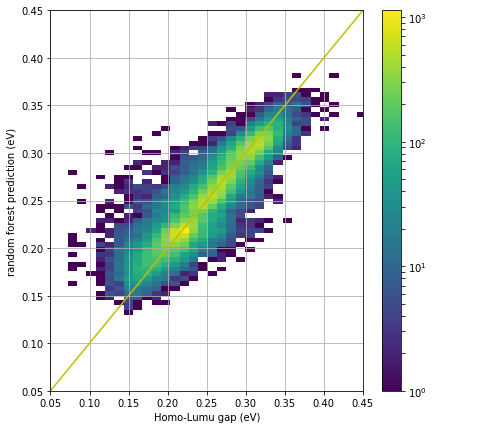

In [67]:
# plot prediction vs actual value

plt.figure(figsize=(7,7))
plt.hist2d(testY, pred, (50,50), norm=matplotlib.colors.LogNorm())
low, high = 0.05,0.45
plt.xlim(low,high)
plt.ylim(low,high)
xx = np.linspace(low,high,10)
plt.plot(xx,xx,'y-')
plt.grid()
plt.colorbar()

plt.xlabel("Homo-Lumu gap (eV)")
plt.ylabel("random forest prediction (eV)")

print "MAE:", np.mean(abs(pred-testY))

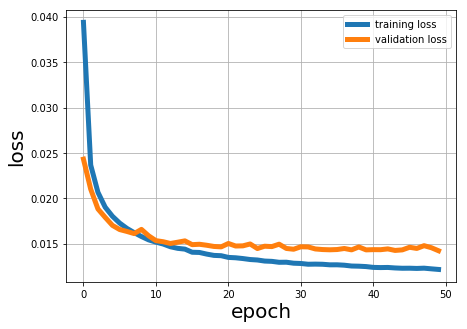

In [68]:
# plot the learning curve

plt.figure(figsize=(7,5))
plt.plot(history.history["loss"], label="training loss", lw=5)
plt.plot(history.history["val_loss"], label = "validation loss", lw=5)
plt.grid()
plt.legend()
plt.xlabel("epoch", size=20)
plt.ylabel("loss", size=20)